<a href="https://colab.research.google.com/github/zdemanche/DLforIDS/blob/main/DLforIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow.lite as tflite

# Define correct column names based on UNSW-NB15 dataset
column_names = [
    "srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes",
    "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts", "Dpkts",
    "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len",
    "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt", "synack", "ackdat",
    "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd",
    "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm",
    "ct_dst_src_ltm", "attack_cat", "label"
]

# Load and merge dataset with correct column names
files = ['UNSW-NB15_1.csv', 'UNSW-NB15_2.csv', 'UNSW-NB15_3.csv', 'UNSW-NB15_4.csv']
df = pd.concat([pd.read_csv(file, names=column_names, skiprows=1) for file in files], ignore_index=True)

# Display column names to verify
print("✅ Columns have been correctly renamed:", df.columns)
print(df.head())  # Show first 5 rows to confirm it's correct

# Handle missing values
df.fillna(0, inplace=True)  # Replace NaNs with 0

df["attack_cat"] = df["attack_cat"].fillna("Unknown")

# Identify the correct target column
if "label" in df.columns:
    target_column = "label"
    print("✅ Using 'label' for binary classification.")
elif "attack_cat" in df.columns:
    target_column = "attack_cat"
    print("✅ Using 'attack_cat' for multi-class classification.")
else:
    print("❌ Error: No valid target column found in dataset.")
    exit()

# Convert categorical columns to numeric
label_encoder = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column].astype(str))

# Define features and target
X = df.drop(columns=[target_column, "attack_cat"], errors='ignore')
y = df[target_column].astype(int)  # Ensure y is an integer

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Build deep learning model
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.1),  # Prevents dead neurons
    Dropout(0.5),
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(32),
    LeakyReLU(alpha=0.1),
    Dense(1, activation='sigmoid') if target_column == "label" else Dense(len(np.unique(y)), activation='softmax')
])

# Compile model with lower learning rate
optimizer = Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy' if target_column == 'label' else 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), class_weight=class_weight_dict, callbacks=[early_stop])

# Evaluate model
y_pred = (model.predict(X_test) > 0.5).astype(int) if target_column == 'label' else model.predict(X_test).argmax(axis=1)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))

# Save model
model.save("IDS_UNSW15_Model.h5")

# Convert model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open("IDS_UNSW15_Model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model converted and saved as TensorFlow Lite format!")

<ipython-input-7-4f25654462a0>:26: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(file, names=column_names, skiprows=1) for file in files], ignore_index=True)
<ipython-input-7-4f25654462a0>:26: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(file, names=column_names, skiprows=1) for file in files], ignore_index=True)


✅ Columns have been correctly renamed: Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload',
       'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime',
       'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'label'],
      dtype='object')
   srcip          sport dstip dsport proto     state  dur  sbytes  dbytes  \
0  33661  149.171.126.9  1024    udp   CON  0.036133  528     304      31   
1   1464  149.171.126.7    53    udp   CON  0.001119  146     178      31   
2   3593  149.171.126.5    53    udp   CON  0.001209  132     164      31   
3  49664  149.171.126.0 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5
15876/15876 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - accuracy: 0.9503 - loss: 0.1415 - val_accuracy: 0.9857 - val_loss: 0.0345
Epoch 2/5
15876/15876 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - accuracy: 0.9857 - loss: 0.0325 - val_accuracy: 0.9874 - val_loss: 0.0292
Epoch 3/5
15876/15876 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - accuracy: 0.9867 - loss: 0.0279 - val_accuracy: 0.9881 - val_loss: 0.0271
Epoch 4/5
15876/15876 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - accuracy: 0.9872 - loss: 0.0268 - val_accuracy: 0.9881 - val_loss: 0.0259
Epoch 5/5
15876/15876 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.9876 - loss: 0.0242 - val_accuracy: 0.9881 - val_loss: 0.0248
 5653/15876 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step

<ipython-input-7-44cb08f71050>:19: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('UNSW-NB15_1.csv', names=column_names, skiprows=1)


Encoding categorical features: ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'dloss', 'attack_cat']


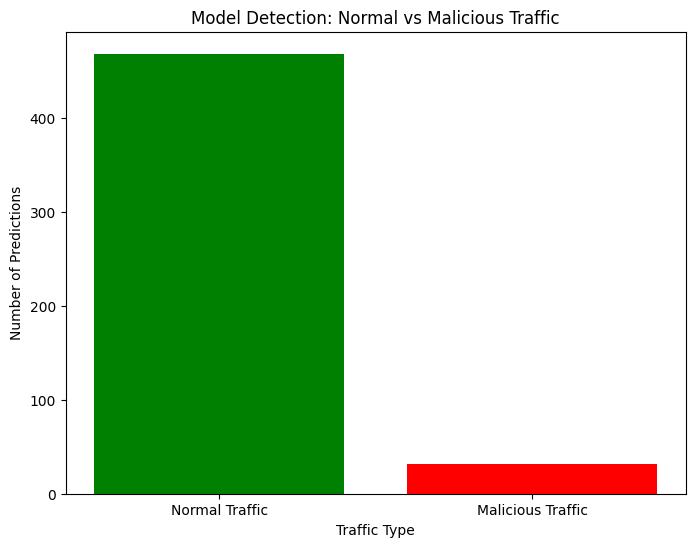

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Define column names for consistency
column_names = [
    "srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes",
    "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts", "Dpkts",
    "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len",
    "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt", "synack", "ackdat",
    "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd",
    "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm",
    "ct_dst_src_ltm", "attack_cat", "label"
]

# Load the dataset
df_test = pd.read_csv('UNSW-NB15_1.csv', names=column_names, skiprows=1)

# Handle missing values
df_test.fillna(0, inplace=True)

# Convert non-numeric categorical columns (proto, state, service) to numeric
categorical_cols = df_test.select_dtypes(include=['object']).columns

if len(categorical_cols) > 0:
    print("Encoding categorical features:", list(categorical_cols))
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_test[col] = le.fit_transform(df_test[col].astype(str))  # Convert to string and encode

# Extract features and normalize
X_test_sample = df_test.drop(columns=["label", "attack_cat"], errors="ignore").astype(float)  # Convert all to float
scaler = StandardScaler()
X_test_sample_scaled = scaler.fit_transform(X_test_sample)

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="IDS_UNSW15_Model.tflite")
interpreter.allocate_tensors()

# Get input/output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Run predictions on a sample batch
num_samples = min(500, len(X_test_sample_scaled))  # Ensure we don't exceed dataset size
normal_count, attack_count = 0, 0

for i in range(num_samples):
    sample = np.expand_dims(X_test_sample_scaled[i], axis=0).astype(np.float32)

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], sample)

    # Run inference
    interpreter.invoke()

    # Get output tensor
    prediction = interpreter.get_tensor(output_details[0]['index'])[0]

    # Binary classification: 0 = Normal, 1 = Attack
    if prediction > 0.5:
        attack_count += 1
    else:
        normal_count += 1

# Create a visualization
labels = ["Normal Traffic", "Malicious Traffic"]
counts = [normal_count, attack_count]

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=["green", "red"])
plt.title("Model Detection: Normal vs Malicious Traffic")
plt.xlabel("Traffic Type")
plt.ylabel("Number of Predictions")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Define categories and counts
labels = ["Normal Traffic", "Malicious Traffic"]
counts = [normal_count, attack_count]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts, color=["green", "red"])

# Annotate bars with exact values
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             str(count), ha='center', fontsize=12, fontweight='bold')

plt.title("Model Detection: Normal vs Malicious Traffic")
plt.xlabel("Traffic Type")
plt.ylabel("Number of Predictions")
plt.yscale("log")  # Apply log scale to fix large differences in count
plt.show()